# **BC COVID-19 Cases Modeling**
            -- This is a project that is still in progress, will be adding recovered case modelling and explore other model to make better predictions
![](./Comparison.png)

In [1]:
import warnings

warnings.filterwarnings('ignore')
# libraries
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from sklearn.preprocessing import StandardScaler
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import adam_v2



In [2]:
# Data source
caseDetailsUrl = 'http://www.bccdc.ca/Health-Info-Site/Documents/BCCDC_COVID19_Dashboard_Case_Details.csv'

In [3]:
bcCasesDf = pd.read_csv(caseDetailsUrl)

In [4]:
bcCasesDf.rename(columns={'Reported_Date':'Reported Date', 'HA': 'Health Authority', 'Age_Group': 'Age Group', 'Classification_Reported': 'Classification Reported'}, inplace=True)

In [5]:
bcCasesDf['Reported Date'] = pd.to_datetime(bcCasesDf['Reported Date'])

In [6]:
bcCasesDf['Reported Date'] = pd.DatetimeIndex(bcCasesDf['Reported Date']).normalize()

In [7]:
bcCasesDf.head()

,Reported Date,Health Authority,Sex,Age Group,Classification Reported
0,2020-01-29,Out of Canada,M,40-49,Lab-diagnosed
1,2020-02-06,Vancouver Coastal,F,50-59,Lab-diagnosed
2,2020-02-10,Out of Canada,F,20-29,Lab-diagnosed
3,2020-02-10,Out of Canada,M,30-39,Lab-diagnosed
4,2020-02-18,Interior,F,30-39,Lab-diagnosed


In [8]:
bcCasesDf.shape

(147346, 5)

In [9]:
lastRow = int(bcCasesDf.shape[0])-1

In [10]:
totalDays = bcCasesDf.loc[lastRow, 'Reported Date'] - bcCasesDf.loc[0, 'Reported Date']
firstReported = bcCasesDf['Reported Date'].min()
latestReported = bcCasesDf['Reported Date'].max()

In [11]:
# check the oldest and latest record
print(f'This data is for a period between {firstReported.strftime("%d %B %Y")} and {latestReported.strftime("%d %B %Y")}')
print(f"For a total of {totalDays.days} days")

This data is for a period between 29 January 2020 and 23 June 2021
For a total of 511 days


In [12]:
currentDatePlusMonth = datetime.now() + relativedelta(days=+40)

In [13]:
bcCasesDf['Classification Reported'].unique()

array(['Lab-diagnosed', 'Epi-linked'], dtype=object)

**Meaning of Epi-linked: http://www.bccdc.ca/health-professionals/clinical-resources/case-definitions/covid-19-(novel-coronavirus)**
Probable - epi-linked case
A person who:

**Has symptoms compatible with COVID-19
AND**

**Had a high-risk exposure with a confirmed d COVID-19 case (i.e. close contact) OR was exposed to a known cluster or outbreak of COVID-19
 AND**

**Has not had a laboratory-based NAAT assay for SARS-CoV-2 completed** 

In [14]:
print('Percentage Lab Diagnosed:{:.2f}'.format(bcCasesDf['Classification Reported'][bcCasesDf['Classification Reported'] == bcCasesDf['Classification Reported'].unique()[0]].count()/bcCasesDf['Reported Date'].count()*100))
print('Percentage Epi-Linked:{:.2f}'.format(bcCasesDf['Classification Reported'][bcCasesDf['Classification Reported'] != bcCasesDf['Classification Reported'].unique()[0]].count()/bcCasesDf['Reported Date'].count()*100))


Percentage Lab Diagnosed:99.24
Percentage Epi-Linked:0.76


In [15]:
bcCasesDf['Diagnosed'] = np.where(bcCasesDf['Classification Reported'] == bcCasesDf['Classification Reported'].unique()[0], 1,
                          np.where(bcCasesDf['Classification Reported'] == bcCasesDf['Classification Reported'].unique()[1], np.nan, np.nan))

# **Daily BC cases**

In [16]:
data = bcCasesDf.groupby(pd.Grouper(key='Reported Date',freq='D'))['Diagnosed'].count()
data.reset_index()
data.head()

Reported Date
2020-01-29    1
2020-01-30    0
2020-01-31    0
2020-02-01    0
2020-02-02    0
Freq: D, Name: Diagnosed, dtype: int64

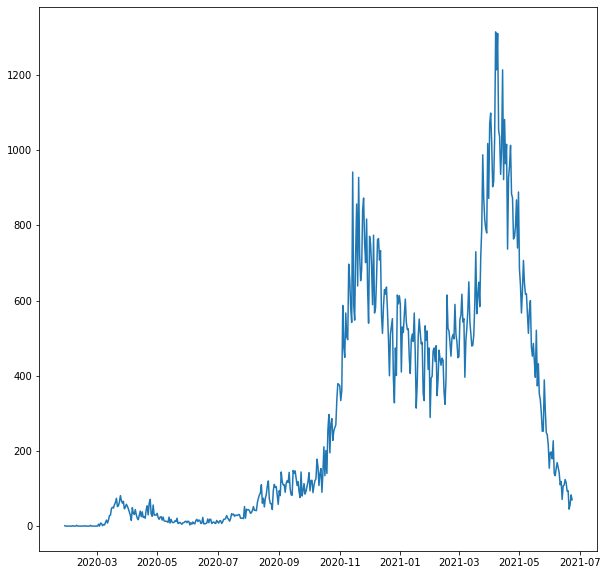

In [17]:
plt.figure(figsize=(10,10))
plt.plot(data)
plt.show()

# **Forcasting using SARIMAX, or Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model**

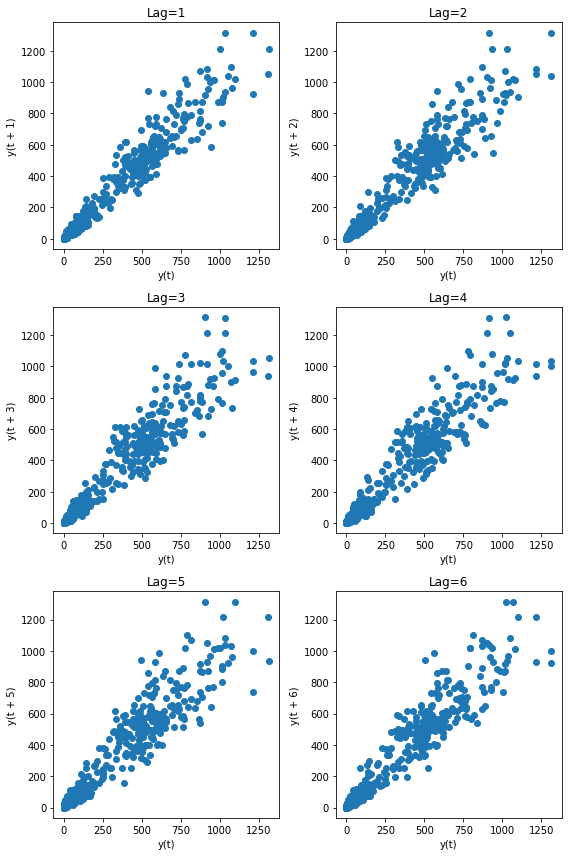

In [18]:
# http://alkaline-ml.com/pmdarima/usecases/stocks.html#viewing-forecasts
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(8, 12))

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(data, lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")
plt.tight_layout()
plt.show()

In [19]:
startDate = '2020-11-01'
data = data.loc[data.index > startDate]
splitDate = '2021-04-01'
train = data.loc[data.index < pd.to_datetime(splitDate)]
test = data.loc[data.index >= pd.to_datetime(splitDate)]
# train.index = pd.DatetimeIndex(train.index).to_period('D')
# test.index = pd.DatetimeIndex(test.index).to_period('D')

In [20]:
print(f'Train {train[:5]},\n Test {test[:5]}')
print(f'Train: {len(train)},\n Test: {len(test)}')

Train Reported Date
2020-11-02    334
2020-11-03    360
2020-11-04    587
2020-11-05    477
2020-11-06    449
Freq: D, Name: Diagnosed, dtype: int64,
 Test Reported Date
2021-04-01    1071
2021-04-02    1099
2021-04-03    1021
2021-04-04     903
2021-04-05     916
Freq: D, Name: Diagnosed, dtype: int64
Train: 150,
 Test: 84


In [21]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


In [22]:
auto = pm.auto_arima(train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1776.670, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1824.147, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1811.332, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1791.596, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1822.311, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1790.588, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1789.449, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1789.987, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1783.518, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1790.879, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1775.688, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1789.7

In [23]:
from pmdarima.metrics import smape

model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean absolute error: {mean_absolute_error(test, forecasts)}")
print(f"SMAPE: {smape(test, forecasts)}")

Mean absolute error: 64.71113593329643
SMAPE: 15.017449249469653


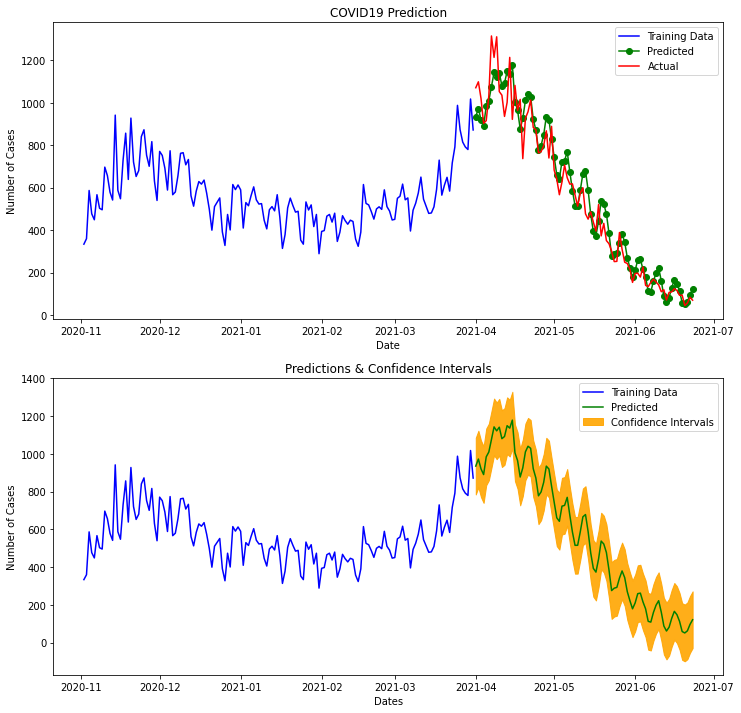

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(train, color='blue', label='Training Data')
axes[0].plot(test.index, forecasts, color='green', marker='o',
             label='Predicted')

axes[0].plot(test.index, test, color='red', label='Actual')
axes[0].set_title('COVID19 Prediction')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Cases')

axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(train, color='blue', label='Training Data')
axes[1].plot(test.index, forecasts, color='green',
             label='Predicted ')

axes[1].set_title('Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Number of Cases')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1789.987, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1824.147, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1811.332, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1791.596, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1822.311, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1789.449, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1800.596, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1790.879, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1776.670, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1790.588, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1783.518, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1775.6

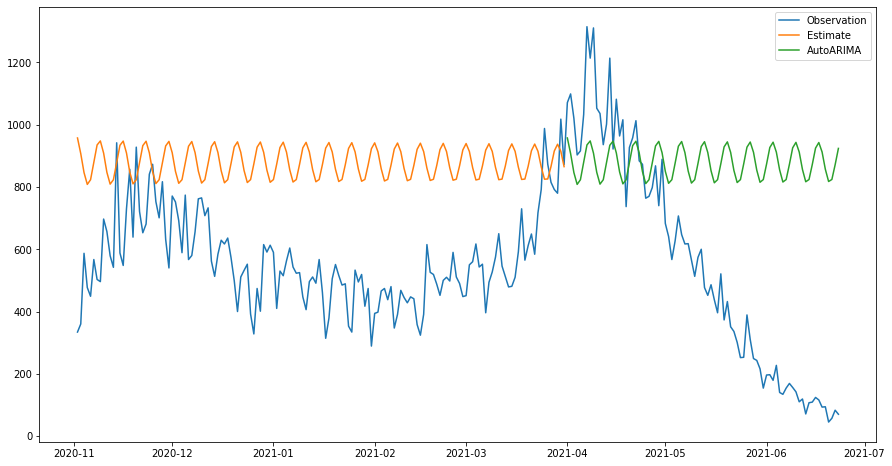

In [25]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3,  # maximum p and q
                      m=4,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())
test.index[-1]
results = model.fit(train)
autoArimaPrediction = results.predict(n_periods=len(test))
len(test.index), len(autoArimaPrediction)
estimate = results.predict(n_periods=len(train))
len(train), len(estimate)

plt.figure(figsize=(15,8))
l1, = plt.plot(data, label='Observation')
l2, = plt.plot(train.index, estimate, label='Estimate')
l3, = plt.plot(test.index, autoArimaPrediction, label='AutoARIMA')
plt.legend(handles=[l1,l2, l3])
plt.show()

In [26]:
model = SARIMAX(train, order=(5,1,3))

In [27]:
results = model.fit(disp=True)

/home/samjoshva/.pyenv/versions/3.8.1/envs/van_covid19_app/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [28]:
sarimaxPrediction = results.predict(start = splitDate, end = test.index[-1], dynamic=False)

In [29]:
sarimaxPrediction

2021-04-01    935.436573
2021-04-02    948.413789
2021-04-03    870.699795
2021-04-04    776.270281
2021-04-05    849.011762
                 ...    
2021-06-19    870.463030
2021-06-20    828.217816
2021-06-21    828.916989
2021-06-22    871.894939
2021-06-23    924.865893
Freq: D, Name: predicted_mean, Length: 84, dtype: float64

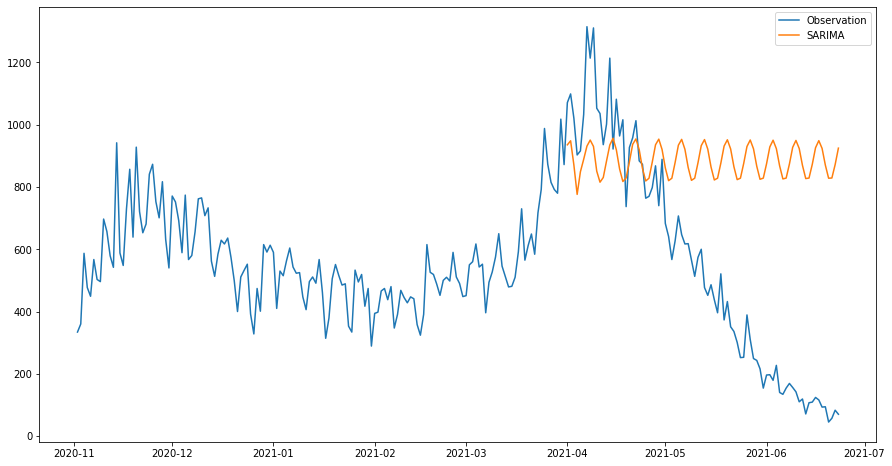

In [30]:
plt.figure(figsize=(15,8))
l1, = plt.plot(data, label='Observation')
l2, = plt.plot(sarimaxPrediction, label='SARIMA')
plt.legend(handles=[l1,l2])

In [31]:
print('SARIMAX MAE = ', mean_absolute_error(sarimaxPrediction, test))

SARIMAX MAE =  414.61269295700976


# **Forcasting using Facebook's Prophet model**

In [32]:
trainDf = pd.DataFrame.from_dict({'ds':train.index, 'y':train})

In [33]:
trainDf.head()

,ds,y
Reported Date,,
2020-11-02,2020-11-02,334
2020-11-03,2020-11-03,360
2020-11-04,2020-11-04,587
2020-11-05,2020-11-05,477
2020-11-06,2020-11-06,449


In [34]:
prophetModel = Prophet(yearly_seasonality=False)
prophetModel.fit(trainDf)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
future = prophetModel.make_future_dataframe(periods=data.shape[0]-train.shape[0])
prophetPrediction = prophetModel.predict(future)

In [36]:
prophetPrediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-11-02,625.248684,425.985669,660.705727,625.248684,625.248684,-87.577908,-87.577908,-87.577908,-87.577908,-87.577908,-87.577908,0.0,0.0,0.0,537.670776
1,2020-11-03,625.917033,527.168170,767.671242,625.917033,625.917033,22.092311,22.092311,22.092311,22.092311,22.092311,22.092311,0.0,0.0,0.0,648.009345
2,2020-11-04,626.585383,564.773694,809.728130,626.585383,626.585383,60.792606,60.792606,60.792606,60.792606,60.792606,60.792606,0.0,0.0,0.0,687.377988
3,2020-11-05,627.253732,553.694677,788.209745,627.253732,627.253732,46.895821,46.895821,46.895821,46.895821,46.895821,46.895821,0.0,0.0,0.0,674.149553
4,2020-11-06,627.922082,526.831719,753.129188,627.922082,627.922082,8.764608,8.764608,8.764608,8.764608,8.764608,8.764608,0.0,0.0,0.0,636.686689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,2021-06-19,1199.053110,1023.171982,1405.329855,1045.927632,1338.678219,19.405320,19.405320,19.405320,19.405320,19.405320,19.405320,0.0,0.0,0.0,1218.458430
230,2021-06-20,1205.052482,952.359912,1324.928183,1048.804323,1350.115877,-70.372757,-70.372757,-70.372757,-70.372757,-70.372757,-70.372757,0.0,0.0,0.0,1134.679724
231,2021-06-21,1211.051853,931.068304,1302.598846,1051.172163,1357.533150,-87.577908,-87.577908,-87.577908,-87.577908,-87.577908,-87.577908,0.0,0.0,0.0,1123.473945
232,2021-06-22,1217.051225,1041.306112,1434.405648,1054.194236,1365.756996,22.092311,22.092311,22.092311,22.092311,22.092311,22.092311,0.0,0.0,0.0,1239.143536


In [37]:
prophetPrediction = prophetPrediction.set_index('ds')
prophetFuture = prophetPrediction.yhat.loc[prophetPrediction.index >= splitDate]
print('Prophet MAE =', mean_absolute_error(prophetFuture, test))

Prophet MAE = 552.1635500412169


In [38]:
prophetFuture

ds
2021-04-01     771.998567
2021-04-02     739.866725
2021-04-03     756.506809
2021-04-04     672.728103
2021-04-05     661.522324
                 ...     
2021-06-19    1218.458430
2021-06-20    1134.679724
2021-06-21    1123.473945
2021-06-22    1239.143536
2021-06-23    1283.843202
Name: yhat, Length: 84, dtype: float64

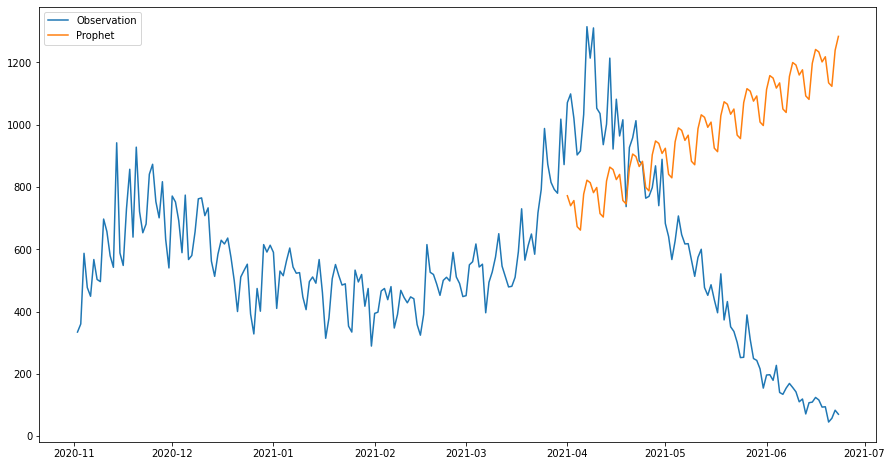

In [39]:
plt.figure(figsize=(15,8))
l1, = plt.plot(data, label='Observation')
l2, = plt.plot(prophetFuture, label='Prophet')
plt.legend(handles=[l1,l2])
plt.show()

# Preparing the dataset for XGBOOST and NN

Unlike the prophet and SAIMAX models, the two models we will train in Task 6, namely XGBOOST and NN, are supervised machine learning models that deal with independent data points, or examples. It assumes that each data point is totally independent from the rest of the data points in the dataset.

Here is a method that extracts these features from a given dataframe object.

In [40]:
data=pd.DataFrame(data)

In [41]:
data.head()

,Diagnosed
Reported Date,
2020-11-02,334
2020-11-03,360
2020-11-04,587
2020-11-05,477
2020-11-06,449


In [42]:
def featurize(t):
    X = pd.DataFrame()
    X['day'] = t.index.day
    X['month'] = t.index.month
    X['quarter'] = t.index.quarter
    X['dayofweek'] = t.index.dayofweek
    X['dayofyear'] = t.index.dayofyear
    X['weekofyear'] = t.index.weekofyear
    y = t.Diagnosed
    return X, y

featurize(data)[0].head()

,day,month,quarter,dayofweek,dayofyear,weekofyear
0,2,11,4,0,307,45
1,3,11,4,1,308,45
2,4,11,4,2,309,45
3,5,11,4,3,310,45
4,6,11,4,4,311,45


# Create training and test datasets by splitting the dataset, and perform data normalization.

In this task we are going to cover two topics in data preparation: splitting the dataset into training and test data, and normalizing the data.

You might have already performed a splitting operation of a dataset in machine learning, where one takes a randomly selected portion of the dataset, say 20%, as a test set, while the remaining 80% is the training set. It is randomly selected because the whole dataset is randomly shufflled before the selection. Another popular approach is the k-fold cross validation.

However, those two methods won't work with time series data. The reason is: when we train the model on the training set, the purpose is to predict the target values in the future, which corresponds to date values that are outside of the date values in the training set.

In [43]:
X_train, y_train = featurize(
data.loc[data.index < pd.to_datetime(splitDate)])
X_test, y_test = featurize(
data.loc[data.index >= pd.to_datetime(splitDate)])



In [44]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [45]:
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

# Train the XGBOOST and NN models

First, create the XGBRegressor object which will represent the XGBOOST regression model.

In [46]:
XGModel = XGBRegressor(n_estimators = 7)

Next, train the XGBOOST regression model using the fit method, and perform prediction using the predict method.

In [47]:
XGModel.fit(scaled_train, y_train,
           eval_set=[(scaled_train, y_train), (scaled_test, y_test)],
           verbose=True)
XGPredictions =  XGModel.predict(scaled_test)

[0]	validation_0-rmse:417.39346	validation_1-rmse:508.39877
[1]	validation_0-rmse:303.98477	validation_1-rmse:428.23264
[2]	validation_0-rmse:223.38812	validation_1-rmse:397.01178
[3]	validation_0-rmse:166.28676	validation_1-rmse:376.24002
[4]	validation_0-rmse:125.48041	validation_1-rmse:377.99100
[5]	validation_0-rmse:96.79755	validation_1-rmse:386.06876
[6]	validation_0-rmse:76.43017	validation_1-rmse:392.48676


Let us calculate the mean absolute error for the training.

In [48]:
print('XGModel MAE = ', mean_absolute_error(XGPredictions, y_test))

XGModel MAE =  342.8272269112723


Creation and training of the feedforward neural network model.

In [49]:
opt = adam_v2.Adam(learning_rate=0.001)
NNModel = Sequential()
NNModel.add(Dense(20, input_shape=(scaled_train.shape[1],)))
NNModel.add(Dense(10))
NNModel.add(Dense(1))
NNModel.compile(loss='mean_absolute_error', optimizer=opt)
NNModel.fit(scaled_train, y_train, validation_data=(
scaled_test, y_test), epochs=220, verbose=1)
NNModelPrediction = NNModel.predict(scaled_test) 

Epoch 1/220
5/5 [==============================] - 11s 90ms/step - loss: 574.8347 - val_loss: 550.3805
Epoch 2/220
5/5 [==============================] - 0s 4ms/step - loss: 560.6839 - val_loss: 550.3216
Epoch 3/220
5/5 [==============================] - 0s 4ms/step - loss: 566.5428 - val_loss: 550.2604
Epoch 4/220
5/5 [==============================] - 0s 4ms/step - loss: 562.6737 - val_loss: 550.2005
Epoch 5/220
5/5 [==============================] - 0s 4ms/step - loss: 572.5328 - val_loss: 550.1393
Epoch 6/220
5/5 [==============================] - 0s 4ms/step - loss: 583.1812 - val_loss: 550.0858
Epoch 7/220
5/5 [==============================] - 0s 4ms/step - loss: 559.4024 - val_loss: 550.0239
Epoch 8/220
5/5 [==============================] - 0s 4ms/step - loss: 562.0912 - val_loss: 549.9559
Epoch 9/220
5/5 [==============================] - 0s 4ms/step - loss: 562.5874 - val_loss: 549.8856
Epoch 10/220
5/5 [==============================] - 0s 3ms/step - loss: 572.8466 - val_lo

Let's compare the MAE values.

In [50]:
print('XGBOOST MAE =', mean_absolute_error(XGPredictions, y_test))
print('Prophet MAE =', mean_absolute_error(prophetFuture, test))
print('SARIMAX MAE =', mean_absolute_error(sarimaxPrediction, test))
print('NN MAE =', mean_absolute_error(NNModelPrediction, test))

XGBOOST MAE = 342.8272269112723
Prophet MAE = 552.1635500412169
SARIMAX MAE = 414.61269295700976
NN MAE = 338.2333348592122


Finally let us visualize the predictions of all 4 models. Note the autofmt_xdate method in matplotlib, it knows how to appropriately rotate the date labels on the x-axis.

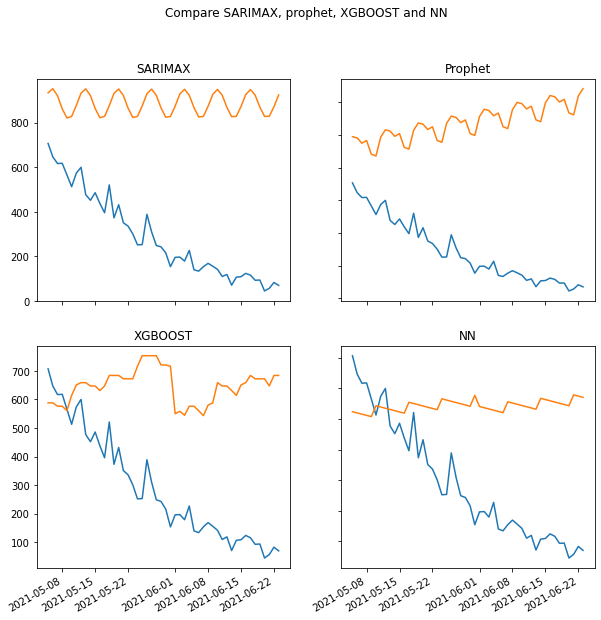

In [51]:

XGDf = pd.DataFrame({'y': XGPredictions.tolist()})
XGDf.index = y_test.index

NNdf = pd.DataFrame(NNModelPrediction)
NNdf.index = y_test.index

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Compare SARIMAX, prophet, XGBOOST and NN')
axs[0, 0].plot(data.tail(50))
axs[0, 0].plot(sarimaxPrediction.tail(50))
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(data.tail(50))
axs[0, 1].plot(prophetFuture.tail(50))
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(data.tail(50))
axs[1, 0].plot(XGDf.tail(50))
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(data.tail(50))
axs[1, 1].plot(NNdf.tail(50))
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('Comparison',
            bbox_inches='tight', transparent=False)

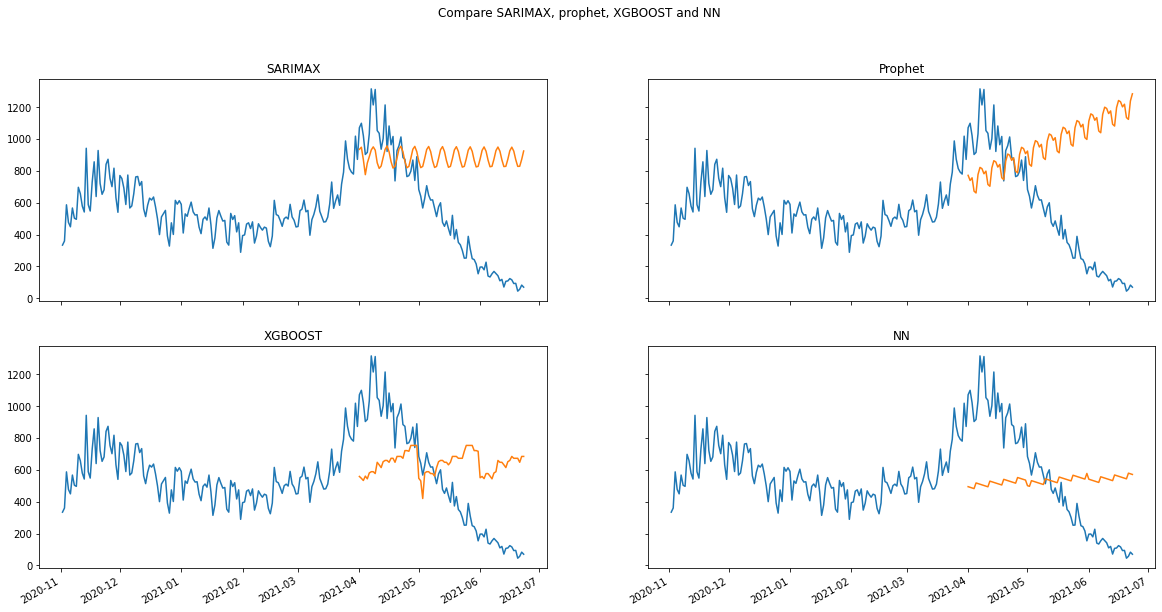

In [52]:

XGDf = pd.DataFrame({'y': XGPredictions.tolist()})
XGDf.index = y_test.index

NNdf = pd.DataFrame(NNModelPrediction)
NNdf.index = y_test.index

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Compare SARIMAX, prophet, XGBOOST and NN')
axs[0, 0].plot(data)
axs[0, 0].plot(sarimaxPrediction)
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(data)
axs[0, 1].plot(prophetFuture)
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(data)
axs[1, 0].plot(XGDf)
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(data)
axs[1, 1].plot(NNdf)
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('Comparison',
            bbox_inches='tight', transparent=False)